# `Strategy` Class

My trading strategies on weekly options are a series of `WeeklyTrials`.  I have a `WeeklyTrial` class created for a simple long-short strategy.  Now lets build  strategy class around it.  It's going to consist of:

1. A set of expiration and execution date pairs.
2. A collection of calculated `WeeklyTrials`
3. A running daily aum that is informed by the daily PNLs of calculated `WeeklyTrials` - the `WeeklyTrial` are also going to be informed by the running AUM, in that as the AUM grows, position sizes should get bigger.  Because of this the WeeklyTrials will have to be fit sequentially, we won't know what size the strategy will be run at until just before it is run.  This is too bad because we won't be able to take advantage of multithreading.
4. A bunch of different PNL metrics.

## Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from WeeklyTrial import WeeklyTrial

## Reading-In All Weekly Expirations

In [ ]:
df_expirations = pd.read_csv('../data/spy_weekly_chains_20100604_20181228.csv')
df_expirations

,underlying,monthly,expiration,last_trade_date,execution
0,SPY,False,2010-06-11,2010-06-11,2010-06-04
1,SPY,True,2010-06-19,2010-06-18,2010-06-11
2,SPY,False,2010-06-25,2010-06-25,2010-06-18
3,SPY,False,2010-07-02,2010-07-02,2010-06-25
4,SPY,False,2010-07-09,2010-07-09,2010-07-02
...,...,...,...,...,...
442,SPY,False,2018-11-30,2018-11-30,2018-11-23
443,SPY,False,2018-12-07,2018-12-07,2018-11-30
444,SPY,False,2018-12-14,2018-12-14,2018-12-07
445,SPY,True,2018-12-21,2018-12-21,2018-12-14


In [ ]:
df_universe = pd.read_csv('../data/universe_per_expiration.csv')
df_universe = df_universe.sort_values(by=['expiration', 'underlying']).reset_index(drop=True)
df_universe

,underlying,monthly,expiration,execution_date,last_trade_date,num_otm
0,DIA,False,2010-06-11,2010-06-04,2010-06-11,15
1,IWM,False,2010-06-11,2010-06-04,2010-06-11,15
2,QQQ,False,2010-06-11,2010-06-04,2010-06-11,6
3,SPY,False,2010-06-11,2010-06-04,2010-06-11,16
4,DIA,True,2010-06-19,2010-06-11,2010-06-18,15
...,...,...,...,...,...,...
13169,XLV,False,2018-12-28,2018-12-21,2018-12-28,15
13170,XLY,False,2018-12-28,2018-12-21,2018-12-28,10
13171,XME,False,2018-12-28,2018-12-21,2018-12-28,9
13172,XOP,False,2018-12-28,2018-12-21,2018-12-28,13


In [ ]:
expiration_universe = \
    list((
    df_universe
        .query('expiration == "2010-12-23"')
        .query('num_otm > 4')
    )['underlying'].values)
expiration_universe

['EEM', 'GDX', 'GLD', 'IWM', 'SLV', 'SPY', 'USO']

## Calculate All Trials for a Strategy

For now I am going to hold all my calculated `WeeklyTrials` in a `Dict`.

In [ ]:
available_universe = [
'DIA',
'IWM',
'QQQ',
'SPY',
'EEM',
'EFA',
'EWW',
'EWY',
'EWZ',
'FXE',
'FXI',
'FXY',
'GDX',
'GLD',
'IYR',
'SLV',
'SMH',
'TLT',
'USO',
'XBI',
'XHB',
'XLB',
'XLE',
'XLI',
'XLK',
'XLP',
'XLV',
'XLY',
'XME',
'XOP',
'XRT',
'HYG',
'XLF',
'XLU',
'UNG',
'EWJ',
'EMB',
'EWH',
'EWU',
'XLC',   
]

In [ ]:
set(available_universe).intersection(set(expiration_universe))

{'EEM', 'GDX', 'GLD', 'IWM', 'SLV', 'SPY', 'USO'}

In [ ]:
%%time
strategy = {}
for _, row in df_expirations.iterrows():
    expiration = row['expiration']
    last_trade_date = row['last_trade_date']
    execution = row['execution']
    #universe = ['DIA','IWM','QQQ','SPY']
    leg_max = 10
    delta_short = 0.1
    delta_long = 0.3
    premium_budget = 2000

    # there is bad data for this date
    if expiration == '2015-12-19':
        continue

    # determining the universe
    expiration_universe = \
    list((
        df_universe
            .query('expiration==@expiration')
            .query('num_otm > 4')
        )['underlying'].values)
    universe = list(set(available_universe).intersection(set(expiration_universe)))
        
    wt = WeeklyTrial( 
            expiration = expiration,
            last_trade_date = last_trade_date,
            execution = execution,
            universe = universe,
            leg_max = leg_max,
            delta_long = delta_long, # delta of long strangles
            delta_short = delta_short, # delta of short strangles
            premium_budget = premium_budget,
            random_long_short = False
        )

    wt.calc_all()
    strategy[expiration] = wt

2010-06-11
2010-06-19
2010-06-25
2010-07-02
2010-07-09
2010-07-17
2010-07-23
2010-07-30
2010-08-06
2010-08-13
2010-08-21
2010-08-27
2010-09-03
2010-09-10
2010-09-18
2010-09-24
2010-10-01
2010-10-08
2010-10-16
2010-10-22
2010-10-29
2010-11-05
2010-11-12
2010-11-20
2010-11-26
2010-12-03
2010-12-10
2010-12-18
2010-12-23
2010-12-31
2011-01-07
2011-01-14
2011-01-22
2011-01-28
2011-02-04
2011-02-11
2011-02-19
2011-02-25
2011-03-04
2011-03-11
2011-03-19
2011-03-25
2011-04-01
2011-04-08
2011-04-16
2011-04-21
2011-04-29
2011-05-06
2011-05-13
2011-05-21
2011-05-27
2011-06-03
2011-06-10
2011-06-18
2011-06-24
2011-07-01
2011-07-08
2011-07-16
2011-07-22
2011-07-29
2011-08-05
2011-08-12
2011-08-20
2011-08-26
2011-09-02
2011-09-09
2011-09-17
2011-09-23
2011-09-30
2011-10-07
2011-10-14
2011-10-22
2011-10-28
2011-11-04
2011-11-11
2011-11-19
2011-11-25
2011-12-02
2011-12-09
2011-12-17
2011-12-23
2011-12-30
2012-01-06
2012-01-13
2012-01-21
2012-01-27
2012-02-03
2012-02-10
2012-02-18
2012-02-24
2012-03-02

## Daily PNLs

In [ ]:
daily_pnls = []
for ix_expiration in strategy.keys():
    daily_pnls.append(strategy[ix_expiration].trial_daily_pnls)
df_daily_pnls = pd.concat(daily_pnls)
df_daily_pnls#.head(10)

,trade_date,dollar_pnl_bid_ask,dollar_pnl_mid
0,2010-06-04,-610.00,-305.00
1,2010-06-07,254.44,254.44
2,2010-06-08,42.01,42.01
3,2010-06-09,30.62,30.62
4,2010-06-10,101.46,101.46
...,...,...,...
0,2018-12-21,-626.00,-313.00
1,2018-12-24,148.32,148.32
2,2018-12-26,-1045.77,-1045.77
3,2018-12-27,402.88,402.88


In [ ]:
df_strategy_pnl = \
    (
    df_daily_pnls
        .groupby(['trade_date'])[['dollar_pnl_bid_ask', 'dollar_pnl_mid']].sum()
        .reset_index()
        .assign(cum_pnl_bid_ask = lambda df: df['dollar_pnl_bid_ask'].cumsum())
        .assign(cum_pnl_mid = lambda df: df['dollar_pnl_mid'].cumsum())
        .assign(highwater = lambda df: df['cum_pnl_mid'].cummax())
        .assign(drawdown = lambda df: df['cum_pnl_mid'] - df['highwater'])
    )
df_strategy_pnl

,trade_date,dollar_pnl_bid_ask,dollar_pnl_mid,cum_pnl_bid_ask,cum_pnl_mid,highwater,drawdown
0,2010-06-04,-610.00,-305.00,-610.00,-305.00,-305.00,0.00
1,2010-06-07,254.44,254.44,-355.56,-50.56,-50.56,0.00
2,2010-06-08,42.01,42.01,-313.55,-8.55,-8.55,0.00
3,2010-06-09,30.62,30.62,-282.93,22.07,22.07,0.00
4,2010-06-10,101.46,101.46,-181.47,123.53,123.53,0.00
...,...,...,...,...,...,...,...
2150,2018-12-21,407.72,720.72,-17998.01,126003.99,126003.99,0.00
2151,2018-12-24,148.32,148.32,-17849.69,126152.31,126152.31,0.00
2152,2018-12-26,-1045.77,-1045.77,-18895.46,125106.54,126152.31,-1045.77
2153,2018-12-27,402.88,402.88,-18492.58,125509.42,126152.31,-642.89


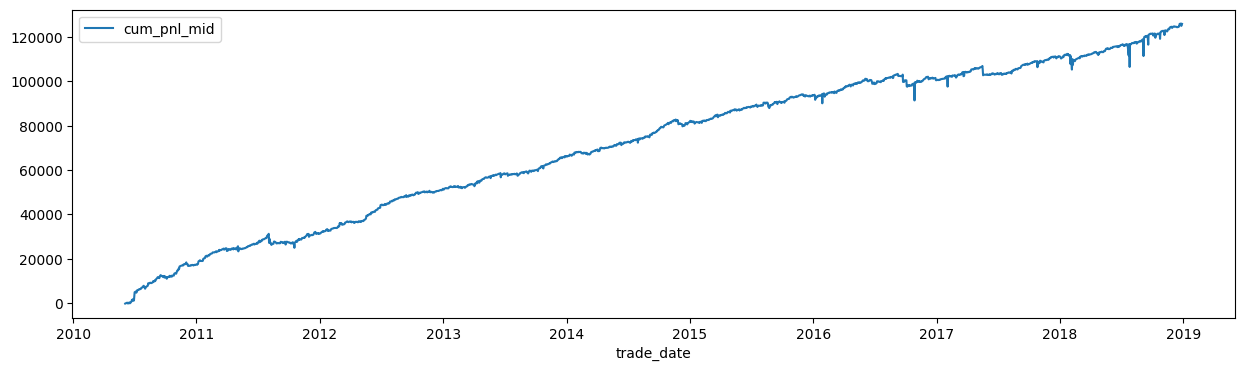

In [ ]:
df_strategy_pnl.plot(x='trade_date', y=['cum_pnl_mid'], figsize=(15, 4));

In [ ]:
ttd_pnl = df_strategy_pnl['cum_pnl_mid'].iloc[-1].round()
ttd_pnl

126018.0

In [ ]:
sharpe_ratio = (df_strategy_pnl['dollar_pnl_mid'].mean() / df_strategy_pnl['dollar_pnl_mid'].std()) * np.sqrt(252)
sharpe_ratio

1.3903732946602223

In [ ]:
sharpe_ratio = (df_strategy_pnl['dollar_pnl_bid_ask'].mean() / df_strategy_pnl['dollar_pnl_bid_ask'].std()) * np.sqrt(252)
sharpe_ratio

-0.2005675715150651

In [ ]:
dvar_99 = np.quantile(df_strategy_pnl['dollar_pnl_mid'], 0.01)
dvar_99

-1818.9724

In [ ]:
max_drawdown = df_strategy_pnl['drawdown'].min()
max_drawdown

-11991.589999999997

In [ ]:
#df_strategy_pnl.sort_values(['drawdown'])

## Collecting Underlying/Expiration Level Statistics

In [ ]:
underlyings = []
for ix_expiration in strategy.keys():
    underlyings.append(strategy[ix_expiration].underlyings)
df_underlyings = pd.concat(underlyings)
df_underlyings

,underlying,direction,expiration,execution,size,quantity,pnl_bid_ask,pnl_mid
0,IWM,1,2010-06-11,2010-06-04,4.0,4.0,-343.88,-307.88
1,SPY,1,2010-06-11,2010-06-04,3.0,3.0,-396.33,-357.33
2,QQQ,-1,2010-06-11,2010-06-04,14.0,-14.0,190.68,260.68
3,DIA,-1,2010-06-11,2010-06-04,10.0,-10.0,285.70,445.70
0,XBI,1,2010-06-19,2010-06-11,1.0,1.0,-102.65,-67.65
...,...,...,...,...,...,...,...,...
15,XLF,-1,2018-12-28,2018-12-21,8.0,-8.0,-4.64,35.36
16,XLV,-1,2018-12-28,2018-12-21,2.0,-2.0,-56.04,-37.04
17,XLE,-1,2018-12-28,2018-12-21,3.0,-3.0,-248.40,-227.40
18,XBI,-1,2018-12-28,2018-12-21,2.0,-2.0,12.24,35.24


## Win Rates for Long and Short Positions

In [ ]:
long_win_count = len(df_underlyings.query('direction > 0 and pnl_mid > 0'))
long_positions = len(df_underlyings.query('direction > 0'))
long_win_rate = (long_win_count / long_positions)
long_win_rate

0.3691529709228824

In [ ]:
short_win_count = len(df_underlyings.query('direction < 0 and pnl_mid > 0'))
short_positions = len(df_underlyings.query('direction < 0'))
short_win_rate = (short_win_count / short_positions)
short_win_rate

0.7919089759797724

In [ ]:
df_pnl_by_direction = df_underlyings.groupby(['expiration', 'direction'])['pnl_mid'].sum().to_frame().reset_index()
df_pnl_by_direction

,expiration,direction,pnl_mid
0,2010-06-11,-1,706.38
1,2010-06-11,1,-665.21
2,2010-06-19,-1,852.48
3,2010-06-19,1,-445.32
4,2010-06-25,-1,1051.05
...,...,...,...
887,2018-12-14,1,-1069.37
888,2018-12-21,-1,1194.05
889,2018-12-21,1,216.71
890,2018-12-28,-1,-750.74


## Hedge-Rate

Let's measure the amount percentage of day that:
1. shorts won and longs lost
2. shorts lost and longs won (hedge rate)
3. shorts won and longs won
4. Shorts lost and longs lost

In [ ]:
df_direction_pnl_by_expiration = \
    (
    df_pnl_by_direction.query('direction > 0')
        .merge(df_pnl_by_direction.query('direction < 0'), on='expiration', suffixes=('_long', '_short'))
    )
df_direction_pnl_by_expiration

,expiration,direction_long,pnl_mid_long,direction_short,pnl_mid_short
0,2010-06-11,1,-665.21,-1,706.38
1,2010-06-19,1,-445.32,-1,852.48
2,2010-06-25,1,55.04,-1,1051.05
3,2010-07-02,1,426.15,-1,3167.40
4,2010-07-09,1,-278.64,-1,1121.15
...,...,...,...,...,...
441,2018-11-30,1,-233.61,-1,190.90
442,2018-12-07,1,-144.93,-1,487.98
443,2018-12-14,1,-1069.37,-1,758.90
444,2018-12-21,1,216.71,-1,1194.05


In [ ]:
shorts_won_longs_lost = df_direction_pnl_by_expiration.query('pnl_mid_short >= 0 and pnl_mid_long < 0').shape[0] / df_direction_pnl_by_expiration.shape[0]
shorts_lost_longs_won = df_direction_pnl_by_expiration.query('pnl_mid_short < 0 and pnl_mid_long >= 0').shape[0] / df_direction_pnl_by_expiration.shape[0]
shorts_won_longs_won = df_direction_pnl_by_expiration.query('pnl_mid_short >= 0 and pnl_mid_long >= 0').shape[0] / df_direction_pnl_by_expiration.shape[0]
shorts_lost_longs_lost = df_direction_pnl_by_expiration.query('pnl_mid_short < 0 and pnl_mid_long < 0').shape[0] / df_direction_pnl_by_expiration.shape[0]

pd.DataFrame({
    'shorts_won_longs_lost':[shorts_won_longs_lost],
    'shorts_lost_longs_won':[shorts_lost_longs_won],
    'shorts_won_longs_won':[shorts_won_longs_won],
    'shorts_lost_longs_lost':[shorts_lost_longs_lost],
                             
}).round(3)

,shorts_won_longs_lost,shorts_lost_longs_won,shorts_won_longs_won,shorts_lost_longs_lost
0,0.612,0.128,0.202,0.058


## Weekly Win Rate (Win Rate by Expiration/Trial)

In [ ]:
df_pnl_by_expiration = \
    (
    df_underlyings
        .groupby(['expiration'])[['pnl_mid']].sum()
        .reset_index()
    )
df_pnl_by_expiration

,expiration,pnl_mid
0,2010-06-11,41.17
1,2010-06-19,407.16
2,2010-06-25,1106.09
3,2010-07-02,3593.55
4,2010-07-09,842.51
...,...,...
441,2018-11-30,-42.71
442,2018-12-07,343.05
443,2018-12-14,-310.47
444,2018-12-21,1410.76


In [ ]:
weekly_win_rate = len(df_pnl_by_expiration.query('pnl_mid > 0'))/len(df_pnl_by_expiration)
weekly_win_rate

0.773542600896861

## Edge-Per-Lot

In [ ]:
options_traded = df_underlyings['size'].sum() * 2
options_traded

77420.0

In [ ]:
df_strategy_pnl['cum_pnl_bid_ask'].iloc[-1] / options_traded

-0.23229772668561124

In [ ]:
df_strategy_pnl['cum_pnl_mid'].iloc[-1] / options_traded

1.6277126065616094

## Other Things to Analyze

1. Total premium bought and sold, maybe try to store that information in the `underlyings` attribute.
2. Total bid-ask spread paid (so sum of half the bid-ask spread).

## OLD CODE

In [ ]:
# expiration = '2010-06-11'
# last_trade_date = '2010-06-11'
# execution = '2010-06-04'
# universe = ['DIA','IWM','QQQ','SPY']
# leg_max = 5 # the maximum number of longs and shorts (for the initial iteration, since I am focused on a small universe this won't matter)
# delta_long = 0.1 # delta of long strangles
# delta_short = 0.1 # delta of short strangles
# premium_budget = 2000 # amount of absolute premium traded (if you trade n underlyings, for each underlying you will buy/sell premium_budget/n premium)

In [ ]:
# test = WeeklyTrial()
# test.calc_all()

In [ ]:
# test.underlyings

In [ ]:
## This yielded good results, probably by chance (when I increased the universe, results go worse):

# available_universe = [
# 'DIA',
# 'IWM',
# 'QQQ',
# 'SPY',
# 'EEM',
# 'EFA',
# 'EWW',
# 'EWY',
# 'EWZ',
# 'FXE',
# 'FXI',
# 'FXY',
# 'GDX',
# 'GLD',
# 'IYR',
# 'SLV',
# 'SMH',
# 'TLT',
# 'USO',
# 'XBI',
# 'XHB',
# 'XLB',
# ]


# expiration = row['expiration']
# last_trade_date = row['last_trade_date']
# execution = row['execution']
# #universe = ['DIA','IWM','QQQ','SPY']
# leg_max = 10
# delta_long = 0.3
# delta_short = 0.1
# premium_budget = 2000